In [1]:
import pandas as pd
import numpy as np

from sklearn import tree

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score as auc

from IPython.display import Image
from sklearn.externals.six import StringIO 

import pydot

In [2]:
def draw_tree(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf, out_file=dot_data)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [4]:
data = pd.read_csv("german_data-numeric.txt", header=None, sep="\\s+")
labels = data.loc[:,24].values
data = data.drop(24, axis=1)
lbl_enc = LabelEncoder()
# 1-->0 ; 2-->1
labels = lbl_enc.fit_transform(labels)

In [5]:
xtrain, xcv, ytrain, ycv = train_test_split(data, labels, test_size=0.3, random_state=709)

In [5]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf.fit(xtrain, ytrain)
print "AUC: " + str(auc(ycv, clf.predict(xcv)))

AUC: 0.611111111111


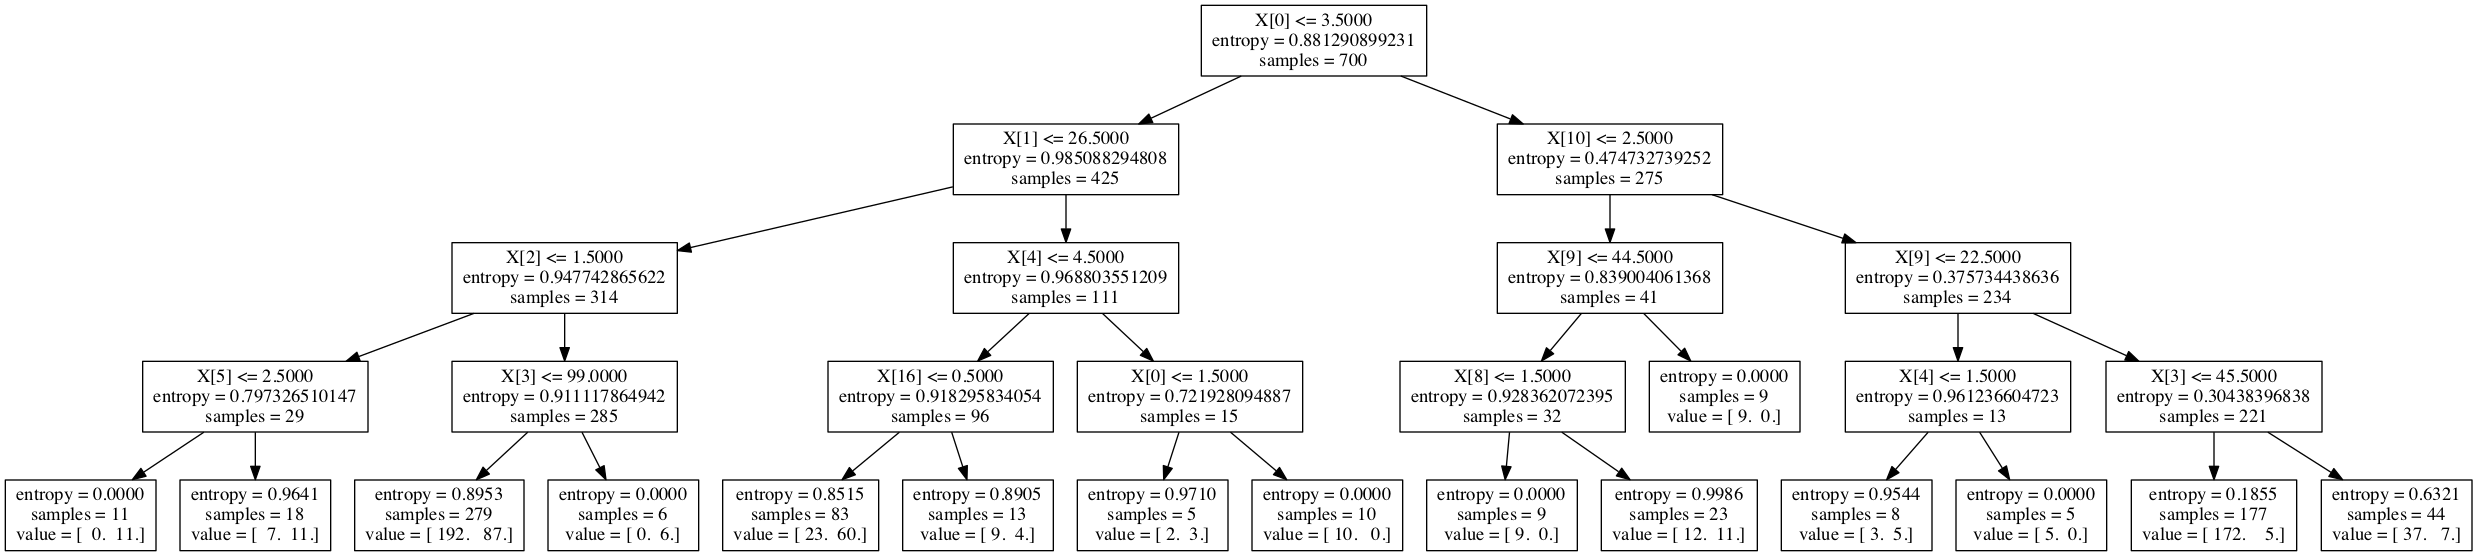

In [7]:
Image(draw_tree(clf), width = 1400, height = 700)

### Как видно, первым делом дерево поделило по нулевому признаку - это текущее состояние счета в банке. Логично, что наличие денег, которые можно положить на счет (фактически "лишние" деньги) играет по сути решающую роль. На втором уровне разделение идет по признаку длительности кредита, очевидно, что если брать кредит на большее время, то вероятность того, что во время его выплаты случатся финансовые трудности выше чем на коротком кредите. Еще один признак на этом уровне это сколько времени человек живет на своем текущем месте. Это при условии, что я правильно сосчитал признаки, поскольку в german_data-numeric признаков на 4 больше, чем в описании к датасету, поэтому некоторые могли быть разделены и номера признаков сместились. Поэтому насчет корректности интерпретации нельзя ничего утверждать ничего наверняка, тк некоторые признаки могли сместиться и занять, к примеру, два столбца. Хорошо, если бы колонки в датасете были сразу бы именованы.
### В любом случае понятно как дерево визуализировать и как его интерпретировать.

### Поэкспереминтировать стоит с глубиной дерева

In [6]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf.fit(xtrain, ytrain)
print "AUC: " + str(auc(ycv, clf.predict(xcv)))

AUC: 0.5


In [8]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
clf.fit(xtrain, ytrain)
print "AUC: " + str(auc(ycv, clf.predict(xcv)))

AUC: 0.638888888889


### Можно поменять критерий

In [13]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=15)
clf.fit(xtrain, ytrain)
print "AUC: " + str(auc(ycv, clf.predict(xcv)))

AUC: 0.611904761905


### Или выставить большую глубину

In [15]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=25)
clf.fit(xtrain, ytrain)
print "AUC: " + str(auc(ycv, clf.predict(xcv)))

AUC: 0.631746031746


### Видно что на маленькой глубине дерево явно недообучилось, а сильное увеличение глубины уже несильно меняет качество

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

C:\Installed\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [17]:
auc_list_gini = []
auc_list_entropy = []
for i in range(1,21):
    auc_meaner = []
    # это чтобы хоть чуть усреднить оценки
    for j in range(1,5):
        clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
        clf.fit(xtrain, ytrain)
        auc_meaner.append(auc(ycv, clf.predict(xcv)))
    auc_list_entropy.append(np.mean(auc_meaner))
    
    auc_meaner = []
    for j in range(1,5):
        clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=i)
        clf.fit(xtrain, ytrain)
        auc_meaner.append(auc(ycv, clf.predict(xcv)))
    auc_list_gini.append(np.mean(auc_meaner))

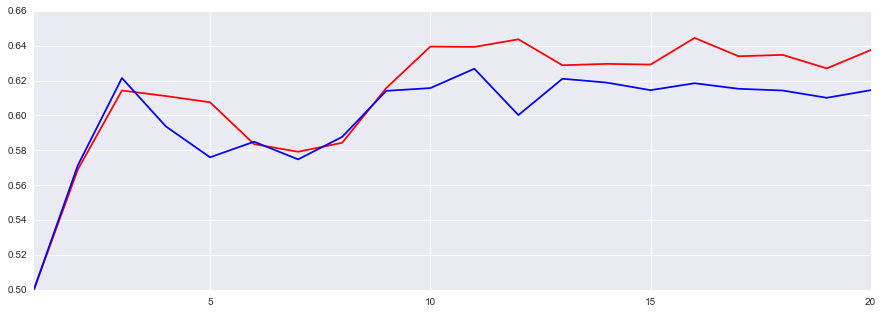

In [18]:
pd.Series(index=range(1,21), data=auc_list_entropy).plot(color='r', figsize=(15,5))
pd.Series(index=range(1,21), data=auc_list_gini).plot(color='b', figsize=(15,5))

### Красным тут выделены деревья с энтропийным критерием, по оси Х - глубина деревьев. По Y - AUC_ROC. Как видно в определенный момент качество перестает расти в зависимости от глубины. Нас тут еще повезло, могло бы так выйти, что при увеличении глубины дерево переобучилось бы и качество начало б падать.

### Теперь попробуем продемонстрировать неустойчивость дерева к небольшим изменениям в обучающей выборке

### Тестовую выборку оставим фиксированной, а обучающую будем менять

In [6]:
xtrain_new, xcv_unused, ytrain_new, ycv_unused = train_test_split(xtrain, ytrain, test_size=0.5)

auc_meaner = []
for j in range(1,11):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
    clf.fit(xtrain_new, ytrain_new)
    auc_meaner.append(auc(ycv, clf.predict(xcv)))
print "AUC: " + str(np.mean(auc_meaner))

AUC: 0.636666666667


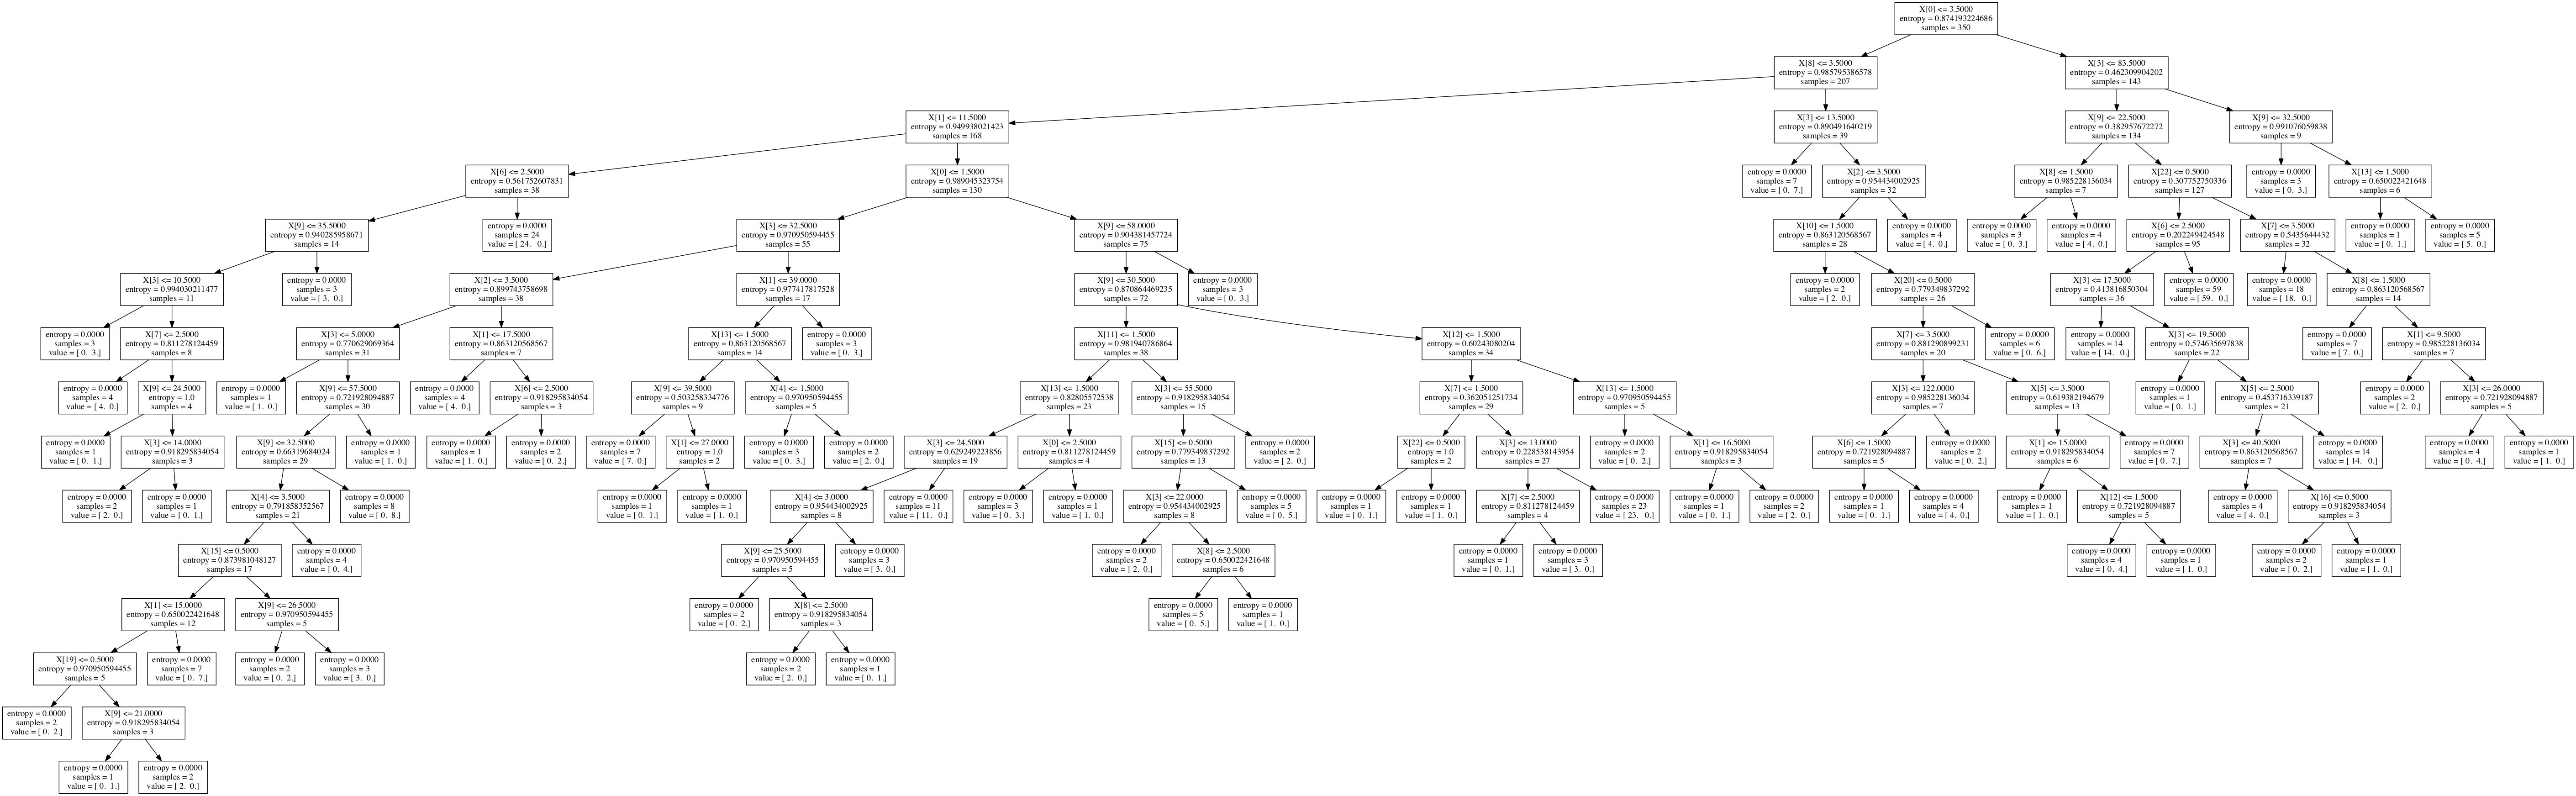

In [7]:
Image(draw_tree(clf), width = 1400, height = 700)

In [8]:
xtrain_new, xcv_unused, ytrain_new, ycv_unused = train_test_split(xtrain, ytrain, test_size=0.5)

auc_meaner = []
for j in range(1,11):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
    clf.fit(xtrain_new, ytrain_new)
    auc_meaner.append(auc(ycv, clf.predict(xcv)))
print "AUC: " + str(np.mean(auc_meaner))

AUC: 0.581984126984


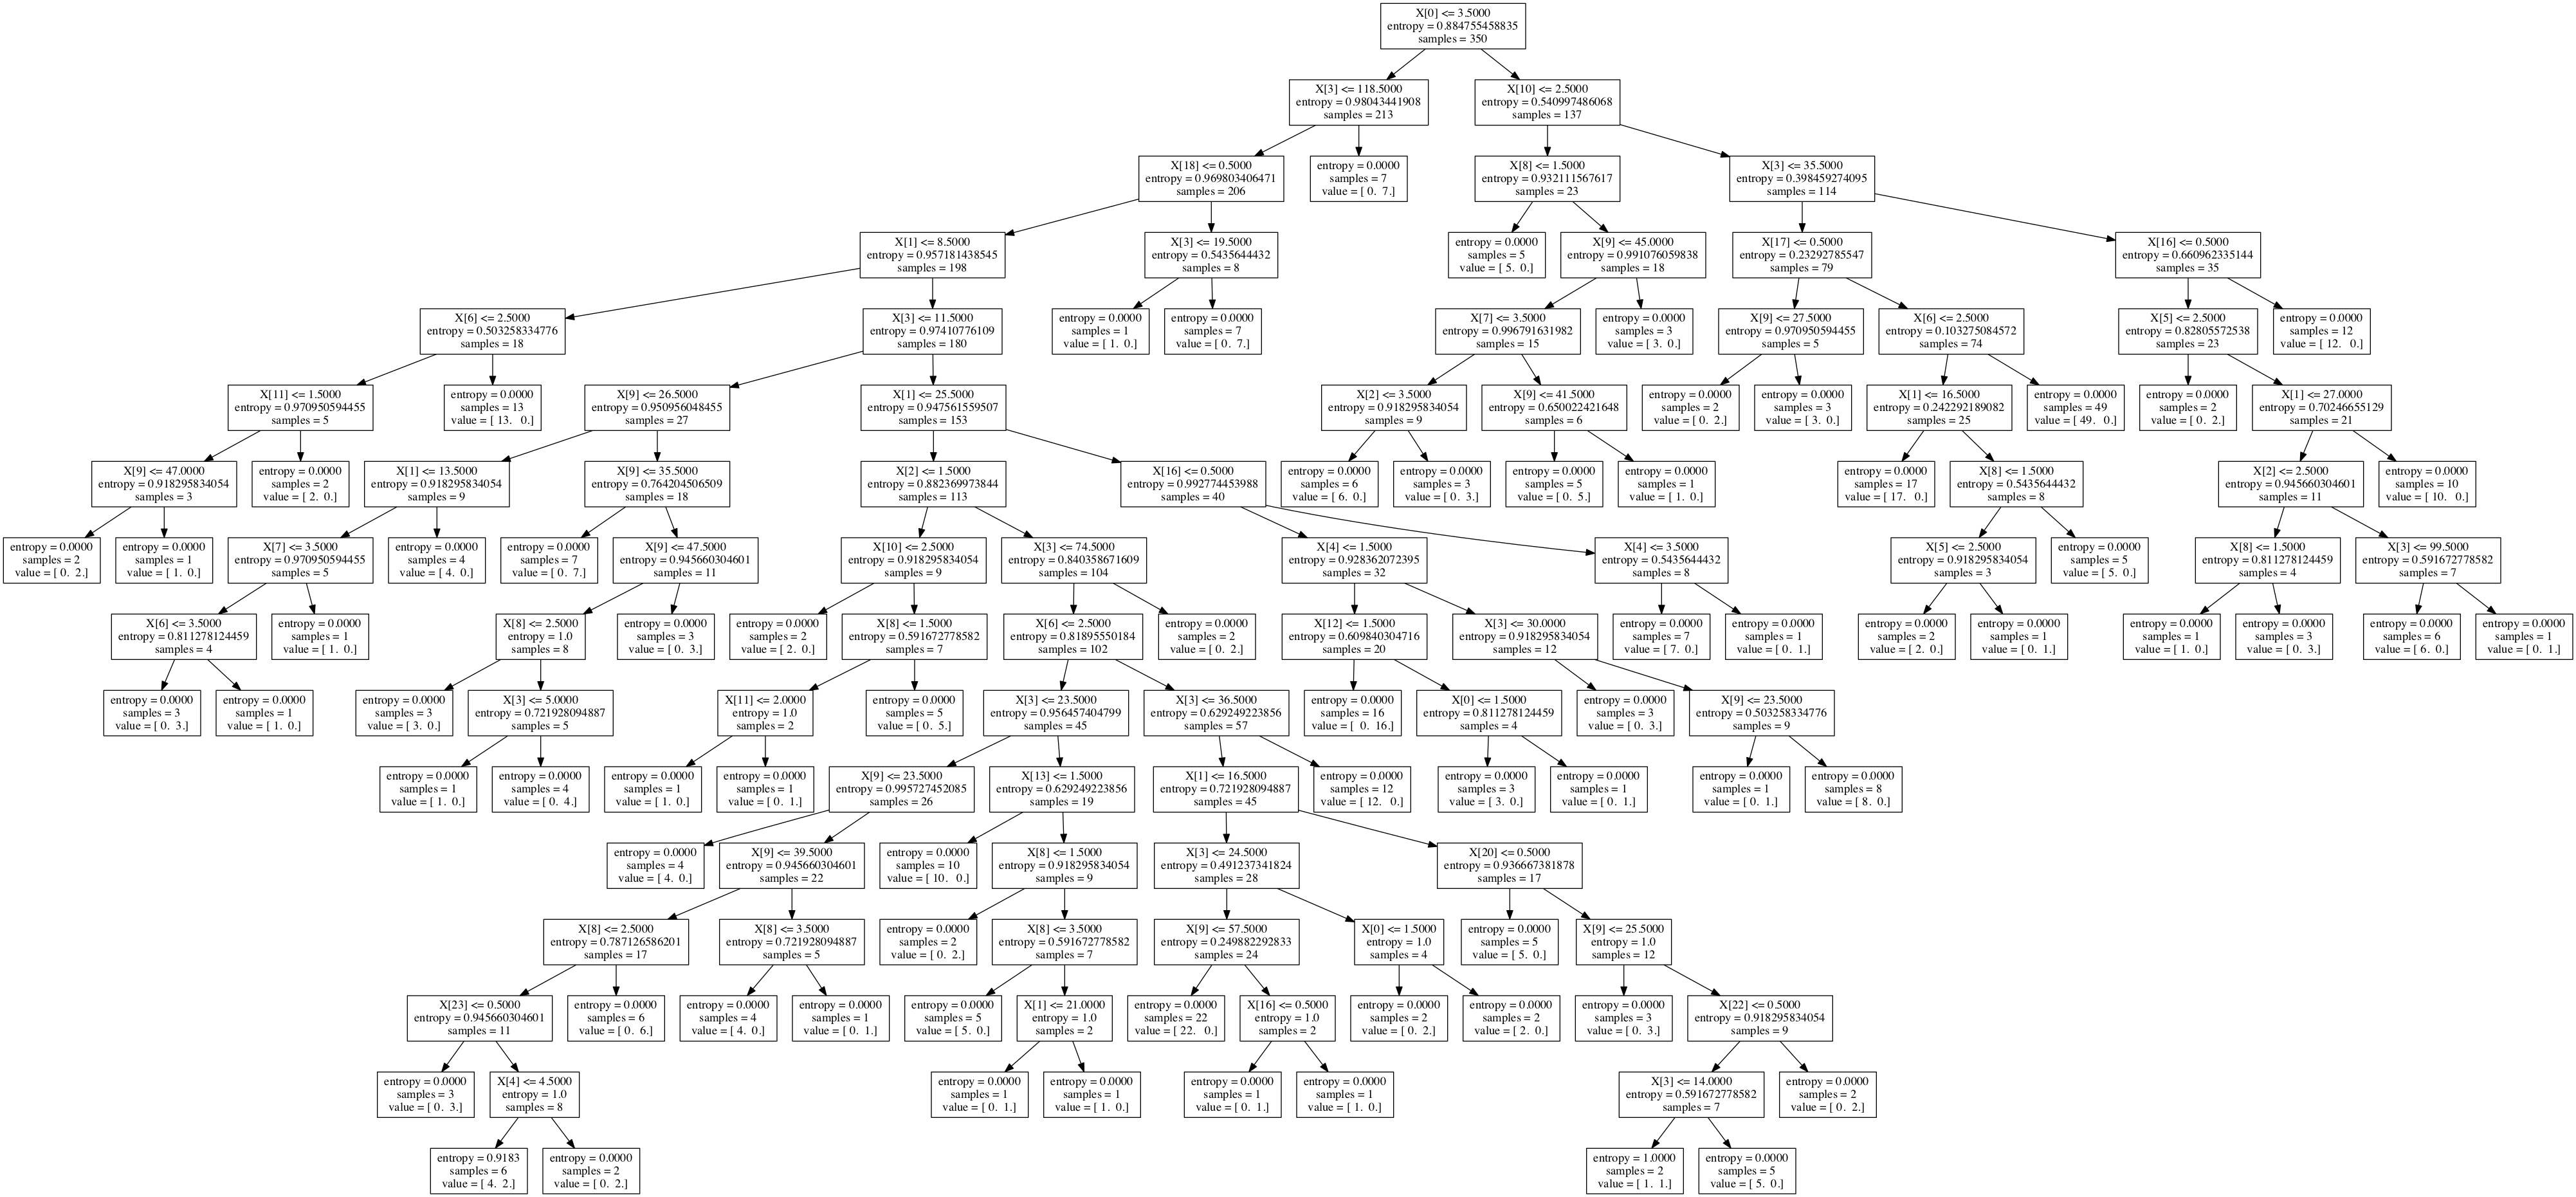

In [9]:
Image(draw_tree(clf), width = 1400, height = 700)

In [10]:
xtrain_new, xcv_unused, ytrain_new, ycv_unused = train_test_split(xtrain, ytrain, test_size=0.5)

auc_meaner = []
for j in range(1,11):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
    clf.fit(xtrain_new, ytrain_new)
    auc_meaner.append(auc(ycv, clf.predict(xcv)))
print "AUC: " + str(np.mean(auc_meaner))

AUC: 0.600952380952


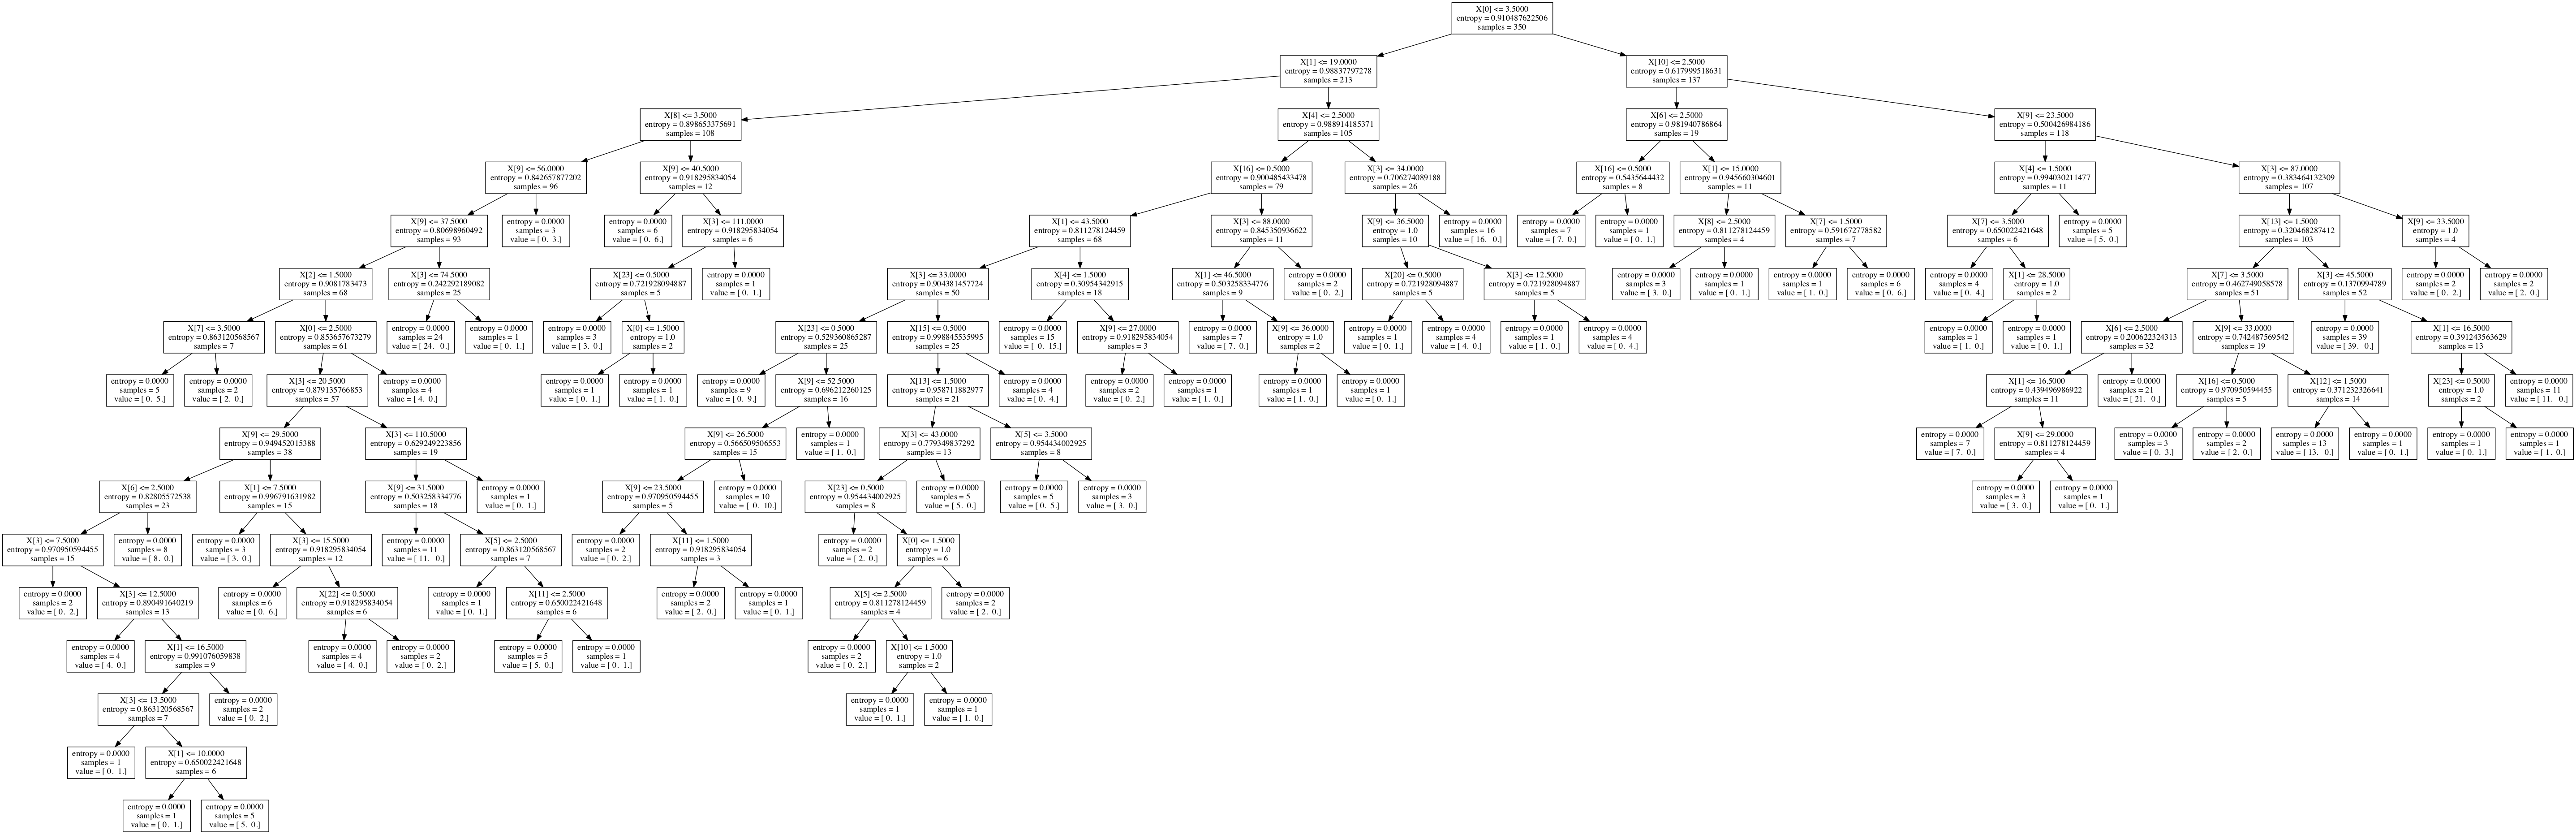

In [11]:
Image(draw_tree(clf), width = 1400, height = 700)

In [18]:
xtrain_new, xcv_unused, ytrain_new, ycv_unused = train_test_split(xtrain, ytrain, test_size=0.5)

auc_meaner = []
for j in range(1,11):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
    clf.fit(xtrain_new, ytrain_new)
    auc_meaner.append(auc(ycv, clf.predict(xcv)))
print "AUC: " + str(np.mean(auc_meaner))

AUC: 0.66873015873


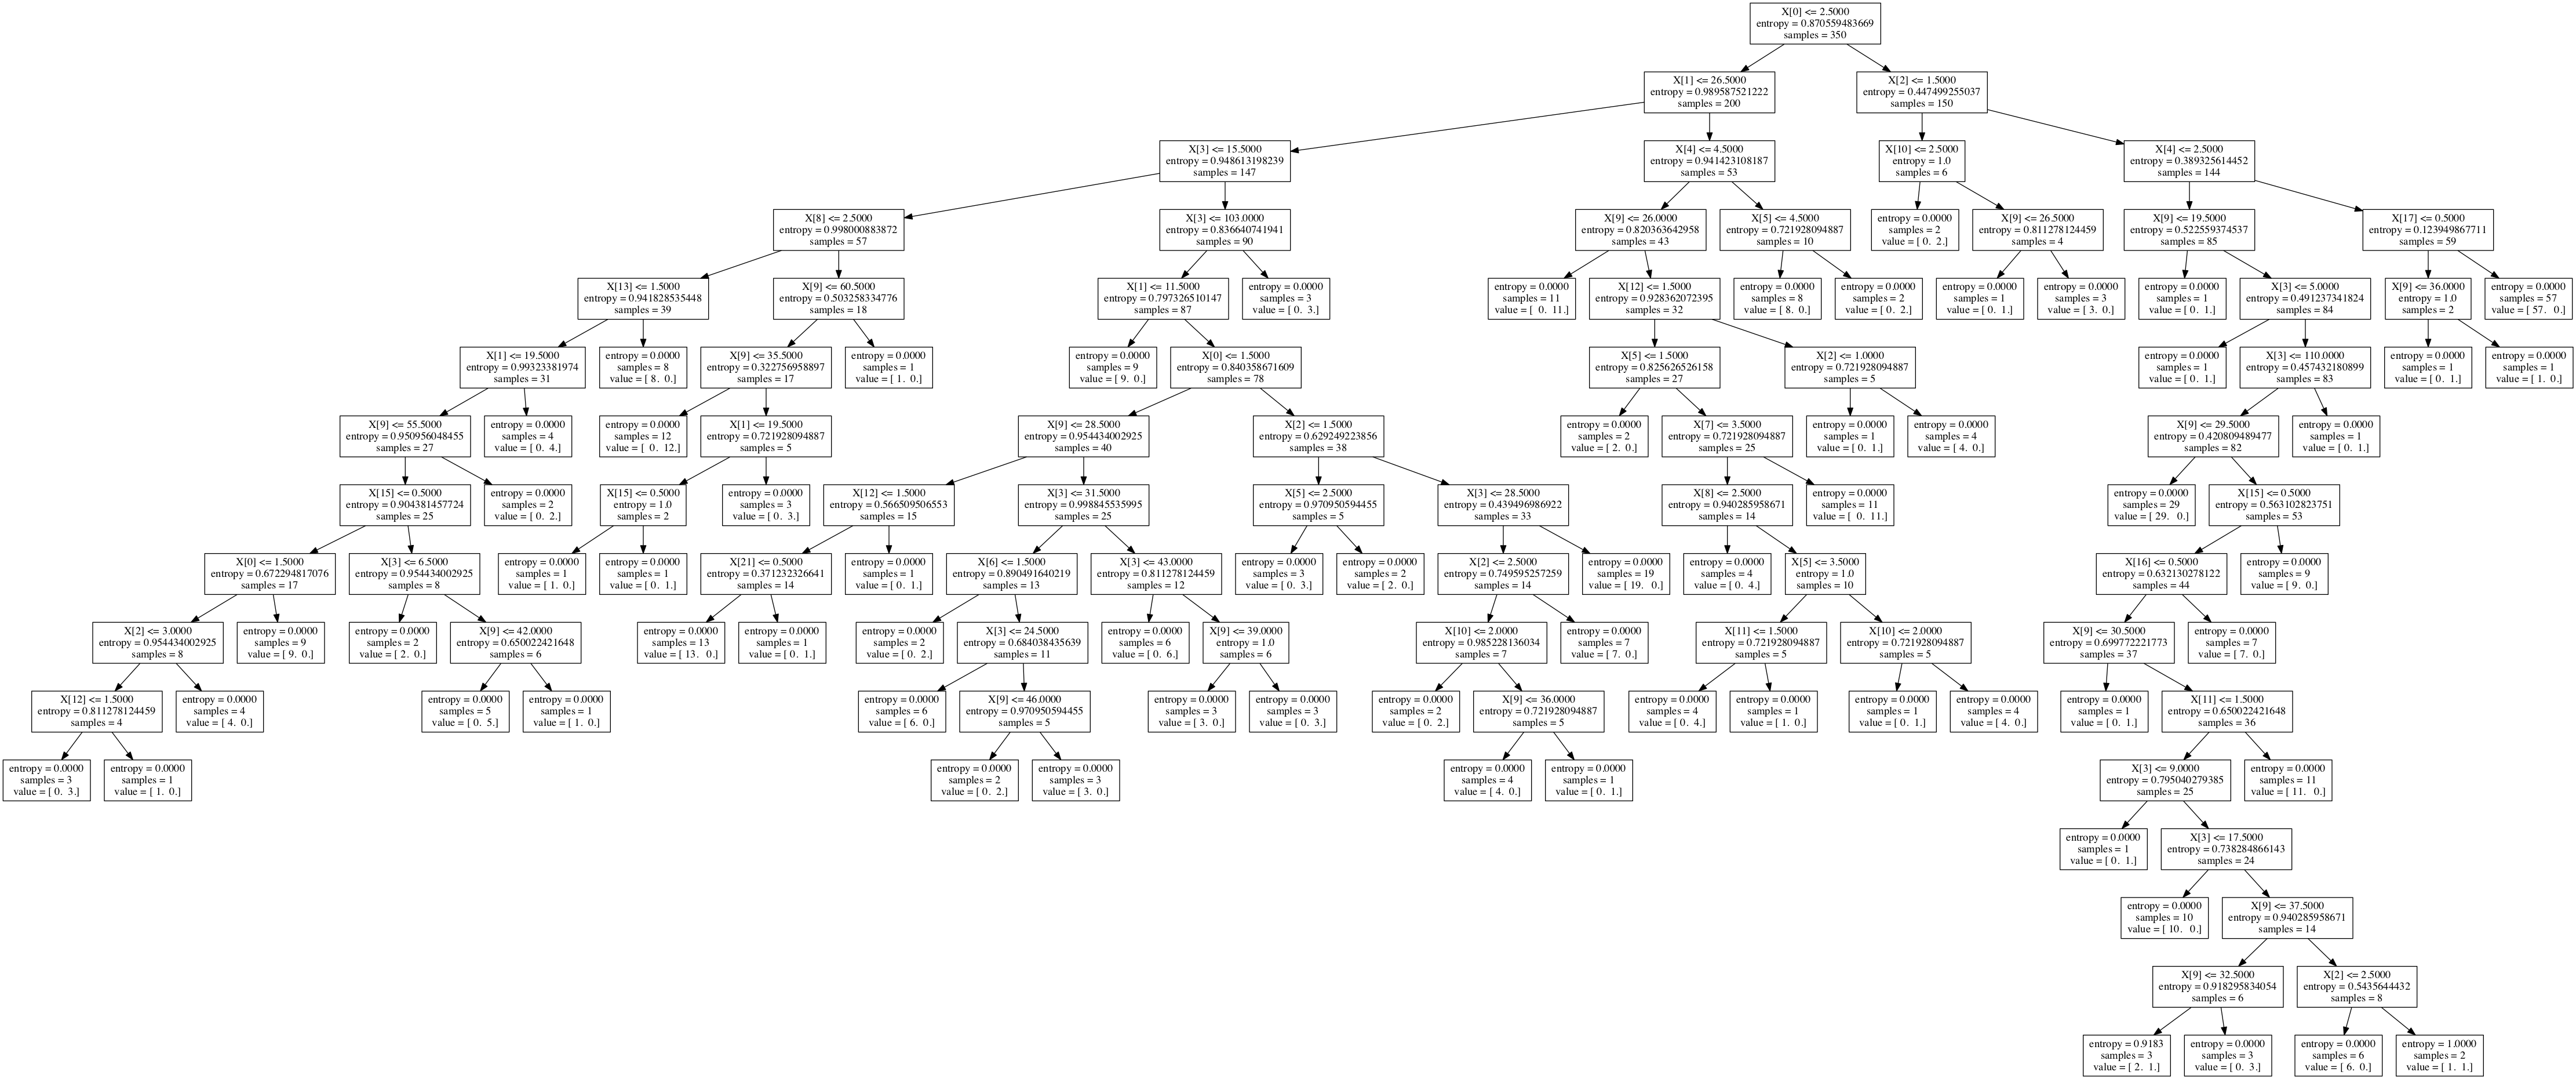

In [19]:
Image(draw_tree(clf), width = 1400, height = 700)

### По факту это 4 одинаковых куска кода, внутри них только train_test_split по разному выделяет обучающую выборку, причем для каждой из выборок дерево строится 10 раз (чтобы наверняка оценку получить верную). Тем не менее видно, что в зависимости от обучающей выборки довольно сильно меняется качество. Это означает что каждый раз дерево отличается по структуре.
### Визуально тоже видно, что они разные. Более того, если сравнить, к примеру, одно из деревьев, которое входит в средний AUC=0.67 и дерево из набора со средним AUC=0.58, то можно увидеть что уже даже на втором уровне дерева разделение идет по разным признакам. В итоге получается что деревья совсем разные.